In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [25]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

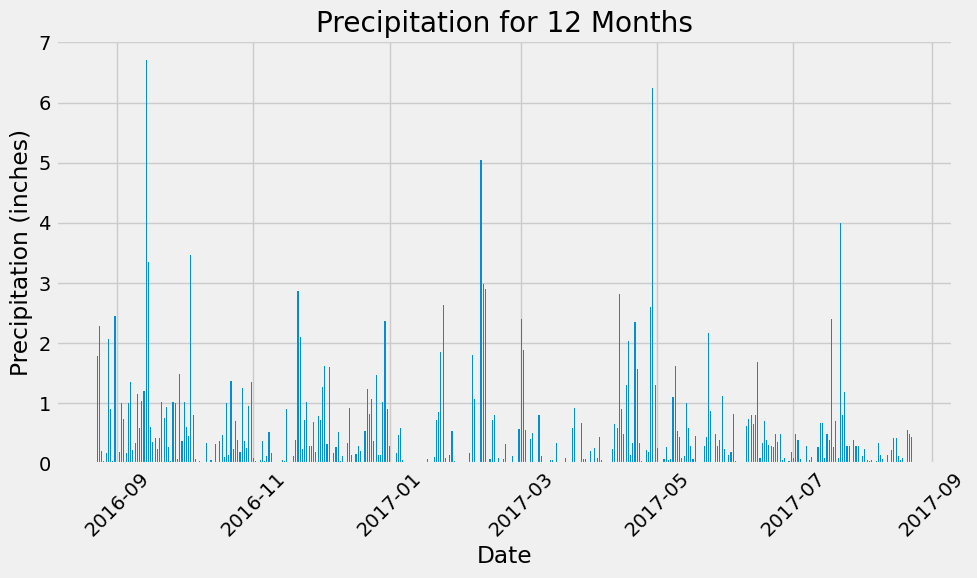

In [28]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
max_date = session.query(func.max(Measurement.date)).scalar()
max_date_minus_one_year = datetime.strptime(max_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
all_measurement_data = session.query(Measurement).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
df_measurement = pd.DataFrame([(m.date, m.prcp) for m in all_measurement_data], columns=['date', 'prcp'])

# Convert 'date' column to datetime objects
df_measurement['date'] = pd.to_datetime(df_measurement['date'])

# Filter the DataFrame for the last 12 months of data
df_one_year_of_data = df_measurement[df_measurement['date'] >= max_date_minus_one_year]

# Sort the dataframe by date
df_one_year_of_data = df_one_year_of_data.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_one_year_of_data['date'], df_one_year_of_data['prcp'], width=0.5)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation for 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Close the session
session.close()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_one_year_of_data['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number of stations in the dataset
len(df_one_year_of_data)

2230

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
measurement_data = session.query(Measurement).all()

df_measurement = pd.DataFrame([(m.id, m.station, m.date, m.prcp, m.tobs) for m in measurement_data],
                              columns=['id', 'station', 'date', 'prcp', 'tobs'])

stations_data = session.query(Stations).all()
df_stations = pd.DataFrame([(s.station, s.name, s.latitude, s.longitude, s.elevation) for s in stations_data],
                           columns=['station', 'name', 'latitude', 'longitude', 'elevation'])


merged_df = pd.merge(df_measurement, df_stations, on='station')
merged_df_sorted = merged_df.sort_values(by='date', ascending=False)

# List the stations and their counts in descending order.
station_counts = merged_df_sorted['station'].value_counts().reset_index()
station_counts = station_counts.rename(columns={'index': 'station', 'station': 'station_count'})
display(station_counts)

,station_count,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [32]:
# Using the most active station id from the previous query (USC00519281), calculate the lowest, highest, and average temperature.
# Query to merge df_measurement and df_station on the column 'station' and filter for 'USC00519281'
merged_df_filtered = pd.merge(df_measurement, df_stations[df_stations['station'] == 'USC00519281'], on='station', how='inner')

merged_df_filtered_sorted = merged_df_filtered.sort_values(by='date', ascending=False)

min_prcp = merged_df_filtered_sorted['tobs'].min()
max_prcp = merged_df_filtered_sorted['tobs'].max()
mean_prcp = merged_df_filtered_sorted['tobs'].mean()

print(f"The min temperature of station USC00519281 is {min_prcp}.")
print(f"The max temperature of station USC00519281 is {max_prcp}.")
print(f"The mean temperature of station USC00519281 is {mean_prcp}.")

The min temperature of station USC00519281 is 54.0.
The max temperature of station USC00519281 is 85.0.
The mean temperature of station USC00519281 is 71.66378066378067.


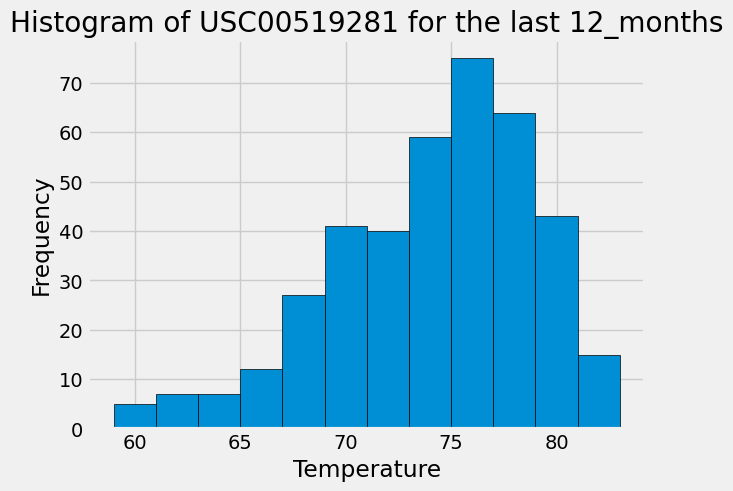

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_USC00519281_12_months = merged_df_filtered_sorted[merged_df_filtered_sorted['date'] >= '2016-07-11']

import matplotlib.pyplot as plt

# Assuming df_USC00519281_12_months is your DataFrame and 'column_name' is the column you want to plot
plt.hist(df_USC00519281_12_months['tobs'], bins=12, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of USC00519281 for the last 12_months')
plt.show()

# Close Session

In [34]:
# Close Session
session.close()